In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_csv('../data/raw/train_lofi_rowid_Nov13.csv')
df_test = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')

df_train.head()

,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


## Figure out if the depth reference point is common, or tied to surface.
1. Looks like the reference is not globally defined, i.e. the 0 depth is at surface. :(
2. The wells have a consistent length (all have 1100 points). So maybe the geological model is flat-surfaced..?


In [2]:
df_train.groupby('well_id').size().describe()

count    4000.0
mean     1100.0
std         0.0
min      1100.0
25%      1100.0
50%      1100.0
75%      1100.0
max      1100.0
dtype: float64

Lets plot a few wells with close `well_id` together in a section

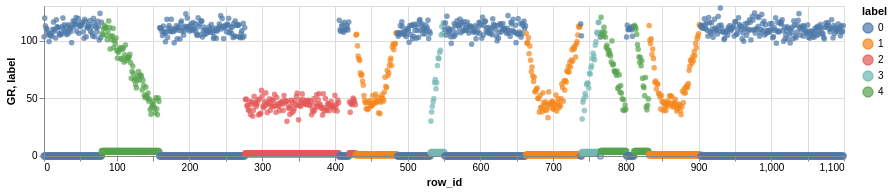

In [59]:
well_ids = df_train['well_id'].unique()[119]
df_sub = df_train[df_train['well_id'] == well_ids]
ch_gr = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_gr + ch_lab

Look at the distribution of labels per well

In [5]:
df_labels = pd.get_dummies(df_train['label'],prefix='lab')
df_labels['well_id'] = df_train['well_id']
df_labels.groupby('well_id').sum().hist(bins=55)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f797edc51d0>,
      dtype=object)

# Prototype a few functions:

In [6]:
from sklearn.linear_model import LinearRegression
def diff_sum(x):
    res = np.diff(x).sum()
    return res
def abs_diff_sum(x):
    res = np.abs(np.diff(x)).sum()
    return res

def rolling_slope(x):
    model_ols =LinearRegression()
    idx=np.arange(x.shape[0])
    model_ols.fit(idx.reshape(-1, 1), x.reshape(-1, 1))
    res = model_ols.coef_[0]
    return res

    
def apply_rolling_functions(df,col='GR',window=10,func ={'mean':np.mean,'std':np.std,'diff_sum':diff_sum,'abs_diff_sum':abs_diff_sum,'slope':rolling_slope}):
    names =[]
    for k,v in func.items():
        series = df[col].rolling(window=window,center=True,min_periods=1).apply(v,raw=True)
        colname = f'{k}_{window}_{col}'
        df.loc[:,colname] = series.values
        names.append(colname)
    df.index = np.arange(df.shape[0])
    return df[names]
def preprocess_a_well(df_well):
    df_feats_w20 = apply_rolling_functions(df_well,window=20)
    df_feats_w60 = apply_rolling_functions(df_well,window=60)
    df_feats_w150 = apply_rolling_functions(df_well,window=150)
    df_feats = pd.concat([df_well,df_feats_w20,df_feats_w60,df_feats_w150],axis=1)
    return df_feats


## Train a simple algorithm in a Grouped KFold manner

### Preprocess data

In [7]:
import tqdm
df_well_list = []
wells = df_train['well_id'].unique().tolist()[:50]
for w in tqdm.tqdm(wells):
    df_well = df_train[df_train['well_id'] == w]
    df_new = preprocess_a_well(df_well.copy())
    df_well_list.append(df_new.copy())
    

100%|██████████| 50/50 [00:36<00:00,  1.34it/s]


In [8]:
df_train_preprocessed = pd.concat(df_well_list,axis=0)
df_train_preprocessed.index = np.arange(df_train_preprocessed.shape[0])

In [9]:
df_well_list[2]

,row_id,well_id,GR,label,mean_20_GR,std_20_GR,diff_sum_20_GR,abs_diff_sum_20_GR,slope_20_GR,mean_60_GR,...,mean_60_GR,std_60_GR,diff_sum_60_GR,abs_diff_sum_60_GR,slope_60_GR,mean_150_GR,std_150_GR,diff_sum_150_GR,abs_diff_sum_150_GR,slope_150_GR
0,0,2,98.146986,0,102.330481,4.130595,2.495593,46.590760,0.029246,103.573749,...,103.573749,4.385600,0.915140,128.285618,-0.038175,102.510180,4.675853,-0.464817,362.542224,-0.039911
1,1,2,109.258152,0,102.938364,4.382460,10.870205,54.965372,0.325876,103.672051,...,103.672051,4.347752,8.474130,135.844607,-0.016165,102.496564,4.646485,3.328424,366.335465,-0.039417
2,2,2,99.504510,0,103.279497,4.345751,8.884976,56.950602,0.408120,103.455475,...,103.455475,4.445930,-1.405361,145.724099,-0.054073,102.536529,4.629344,7.426887,370.433928,-0.034826
3,3,2,100.374358,0,103.364987,4.185752,6.243884,59.591693,0.357304,103.293945,...,103.293945,4.472388,-0.021997,147.107463,-0.077807,102.584116,4.618489,8.101330,371.108371,-0.029890
4,4,2,101.262440,0,103.033227,4.207124,0.573358,65.262219,0.153139,103.197073,...,103.197073,4.441129,1.853312,148.982772,-0.087744,102.645796,4.621382,9.309833,372.316874,-0.024143
5,5,2,101.671252,0,103.254481,4.147921,8.205044,72.893904,0.207396,103.077320,...,103.077320,4.432571,0.858705,149.977379,-0.100391,102.640284,4.592669,4.057842,377.568866,-0.023657
6,6,2,105.654719,0,103.646158,4.293144,11.374330,76.063191,0.309035,103.189709,...,103.189709,4.420862,8.976358,158.095032,-0.074026,102.674819,4.574672,7.290616,380.801640,-0.020265
7,7,2,109.541879,0,104.072880,4.501152,12.753447,77.442308,0.399770,103.096117,...,103.096117,4.396720,1.579822,165.491569,-0.082960,102.711009,4.558343,7.495434,381.006458,-0.016916
8,8,2,97.247938,0,104.516371,4.741143,13.908742,78.597602,0.476699,103.058374,...,103.058374,4.344552,3.514906,167.426654,-0.082385,102.731524,4.534607,6.266772,382.235121,-0.014846
9,9,2,100.642579,0,104.599886,4.628272,7.956154,84.550189,0.430248,103.033773,...,103.033773,4.291172,3.951948,167.863695,-0.079896,102.787484,4.536274,9.285190,385.253539,-0.010372


### Train a model

In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score,accuracy_score
from sklearn.dummy import DummyClassifier
X = df_train_preprocessed.drop(columns=['row_id','label','well_id'])
y = df_train_preprocessed['label']
groups = df_train_preprocessed['well_id']
group_kfold = GroupKFold(n_splits=5)

for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LGBMClassifier(class_weight='balanced',n_jobs=1)
    dumbo = DummyClassifier(strategy='most_frequent')
    dumbo.fit(X_train,y_train)
    model.fit(X_train,y_train)
    
    score = f1_score(y_test,model.predict(X_test),average='weighted')
    acc = accuracy_score(y_test,model.predict(X_test))
    
    score_dumb = f1_score(y_test,dumbo.predict(X_test),average='weighted')
    acc_dumb = accuracy_score(y_test,dumbo.predict(X_test))
    
    print(f'f1 score = {score} , accuracy = {acc}')
    print(f'Dummy f1 score = {score_dumb} , Dummy accuracy = {acc_dumb}')  


/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score = 0.8872695884607005 , accuracy = 0.8863636363636364
Dummy f1 score = 0.35806044678055193 , Dummy accuracy = 0.522
f1 score = 0.8857300025003316 , accuracy = 0.8859090909090909
Dummy f1 score = 0.3430751769320099 , Dummy accuracy = 0.5087272727272727
f1 score = 0.8988268575928188 , accuracy = 0.8973636363636364
Dummy f1 score = 0.35981839879793215 , Dummy accuracy = 0.5235454545454545
f1 score = 0.8920672049506971 , accuracy = 0.8907272727272727
Dummy f1 score = 0.36427702329809225 , Dummy accuracy = 0.5274545454545455
f1 score = 0.8880358721347565 , accuracy = 0.8877272727272727
Dummy f1 score = 0.37031812789819907 , Dummy accuracy = 0.5327272727272727


/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


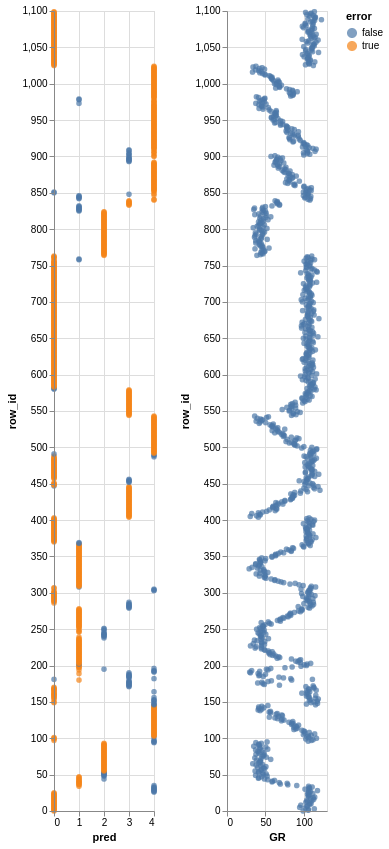

In [41]:
from yellowbrick.classifier import confusion_matrix

df_recent_test = df_train_preprocessed.iloc[test_index,:]
df_recent_test['pred'] = model.predict(X_test)
#visualizer = confusion_matrix(model,X_test,y_test,is_fitted=True)
well_id = 0
df_one_well = df_recent_test.loc[df_recent_test['well_id'].isin([well_id]) ,['row_id','GR','label','pred']]
df_one_well['error'] = df_recent_test['label'] ==  df_recent_test['pred']
ch_gr = alt.Chart(df_one_well,height=800,width=100).encode(y='row_id',x='GR',order='row_id').mark_point(filled=True)
ch_label = alt.Chart(df_one_well,height=800,width=100).encode(y='row_id',x='pred',color='error',order='row_id').mark_point(filled=True)

ch_label | ch_gr

### Run dummy on test and prep a submission

In [22]:
import tqdm
df_well_list_test = []
wells_test = df_test['well_id'].unique().tolist()
for w in tqdm.tqdm(wells_test):
    df_well = df_test[df_test['well_id'] == w]
    df_new = preprocess_a_well(df_well.copy())
    df_well_list_test.append(df_new.copy())
df_test_preprocessed = pd.concat(df_well_list_test,axis=0)
df_test_preprocessed.index = np.arange(df_test_preprocessed.shape[0])

100%|██████████| 350/350 [04:31<00:00,  1.35it/s]


In [24]:
df_test_preprocessed.tail()

,row_id,well_id,GR,mean_20_GR,std_20_GR,diff_sum_20_GR,abs_diff_sum_20_GR,slope_20_GR,mean_60_GR,std_60_GR,...,mean_60_GR,std_60_GR,diff_sum_60_GR,abs_diff_sum_60_GR,slope_60_GR,mean_150_GR,std_150_GR,diff_sum_150_GR,abs_diff_sum_150_GR,slope_150_GR
384995,1095,5349,134.221769,127.554726,6.002246,2.500134,100.036230,0.137695,127.065247,5.358554,...,127.065247,5.358554,3.684930,212.445466,0.048411,122.876934,18.397732,77.915231,479.151857,0.327365
384996,1096,5349,135.804491,127.376134,6.174292,5.557527,96.978837,0.251898,127.012159,5.427706,...,127.012159,5.427706,5.596954,210.533442,0.062464,123.740694,16.824821,81.099872,475.967216,0.273513
384997,1097,5349,126.124399,127.405250,6.406440,6.482308,96.054056,0.300314,127.013795,5.509322,...,127.013795,5.509322,8.085466,208.044930,0.068014,124.667430,14.793763,80.761528,475.628871,0.211957
384998,1098,5349,117.591583,127.516284,6.656005,15.765916,86.770447,0.321654,127.093298,5.576070,...,127.093298,5.576070,5.036239,204.995702,0.059208,125.613843,12.322064,79.357862,474.225206,0.145606
384999,1099,5349,132.555150,128.491470,6.076021,7.436606,78.441137,-0.166961,127.079569,5.664761,...,127.079569,5.664761,3.699783,203.659247,0.067875,126.566693,9.160845,73.545930,468.413274,0.075203


In [28]:
submission_dummy = df_test_preprocessed.loc[:,['row_id','well_id']]
submission_dummy['label'] = dumbo.predict(df_test_preprocessed.drop(columns=['row_id','well_id']))
submission_dummy.to_csv('../data/final/dummy.csv',index=False)
